In [1]:
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 75.3 MB/s eta 0:00:00


In [2]:
import re
import torch
import numpy as np
import faiss
from typing import List, Dict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer

# ============================================================
# DEVICE
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# ============================================================
# MODULE 1 — DATA INGESTION (NO SPACY)
# ============================================================

def load_raw_wikipedia(path: str) -> str:
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def normalize_text(text: str) -> str:
    lines = text.splitlines()
    cleaned = [line.strip() for line in lines if line.strip()]
    return "\n".join(cleaned)

# Simple sentence splitting (stable with NumPy 2.x)
def split_into_sentences(text: str) -> List[str]:
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s.strip() for s in sentences if s.strip()]

def ingest_wikipedia(path: str) -> List[str]:
    raw = load_raw_wikipedia(path)
    normalized = normalize_text(raw)
    return split_into_sentences(normalized)

# ============================================================
# MODULE 2 — CHUNKING
# ============================================================

def count_tokens(text: str) -> int:
    return int(len(text.split()) / 0.75)

def build_chunks(
    sentences: List[str],
    min_tokens=300,
    max_tokens=600,
    overlap_tokens=100
) -> List[Dict]:

    chunks = []
    current = []
    current_tokens = 0
    chunk_id = 0

    for sentence in sentences:
        t = count_tokens(sentence)

        if current_tokens + t > max_tokens:
            if current_tokens >= min_tokens:
                chunks.append({
                    "chunk_id": chunk_id,
                    "text": " ".join(current),
                    "token_count": current_tokens
                })
                chunk_id += 1

            overlap = []
            overlap_count = 0
            for s in reversed(current):
                st = count_tokens(s)
                if overlap_count + st > overlap_tokens:
                    break
                overlap.insert(0, s)
                overlap_count += st

            current = overlap
            current_tokens = overlap_count

        current.append(sentence)
        current_tokens += t

    if current_tokens >= min_tokens:
        chunks.append({
            "chunk_id": chunk_id,
            "text": " ".join(current),
            "token_count": current_tokens
        })

    return chunks

# ============================================================
# MODULE 3 — RETRIEVAL (E5-LARGE)
# ============================================================

def load_embedding_model():
    return SentenceTransformer("intfloat/e5-large", device=DEVICE)

def embed_chunks(model, chunks):
    texts = ["passage: " + c["text"] for c in chunks]
    embeddings = model.encode(
        texts,
        batch_size=16,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    return np.array(embeddings).astype("float32")

def build_faiss_index(embeddings):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)
    return index

def retrieve_top_k(question, model, index, chunks, k=3):
    query_embedding = model.encode(
        ["query: " + question],
        normalize_embeddings=True
    ).astype("float32")

    scores, ids = index.search(query_embedding, k)

    results = []
    for idx, score in zip(ids[0], scores[0]):
        results.append((chunks[idx], float(score)))

    return results

# ============================================================
# MODULE 4 — FLAN-T5 ANSWERER
# ============================================================

# ============================================================
# UPDATED ANSWERER LOADER (MODEL SWITCH ENABLED)
# ============================================================

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def load_answerer_model(model_name="google/flan-t5-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()
    return tokenizer, model


def build_prompt(question, retrieved_chunks):
    context = "\n\n".join(chunk["text"] for chunk in retrieved_chunks)

    return (
        "Answer the question using ONLY the provided text.\n"
        "Do not add information.\n"
        "If the answer is not in the text, say:\n"
        "\"Not enough information in the Simple Wikipedia dataset.\"\n"
        "Use simple English and write at most 3 short sentences.\n\n"
        f"Question: {question}\n\n"
        f"Text: {context}"
    )

def generate_raw_answer(question, retrieved_chunks, tokenizer, model):
    prompt = build_prompt(question, retrieved_chunks)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=80,
            do_sample=False,
            temperature=0.0
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ============================================================
# MODULE 5 — POST PROCESSING
# ============================================================

def post_process(answer, retrieved_chunks):

    answer = re.sub(r"\([^)]*\)", "", answer)

    sentences = re.split(r'(?<=[.!?])\s+', answer)
    sentences = [s.strip() for s in sentences if s.strip()]
    sentences = sentences[:3]

    final = " ".join(sentences).strip()

    if not final:
        return "Not enough information in the Simple Wikipedia dataset."

    retrieved_text = " ".join(c["text"] for c in retrieved_chunks).lower()
    retrieved_words = set(retrieved_text.split())
    answer_words = final.lower().split()

    unseen = [w for w in answer_words if w not in retrieved_words]

    if len(unseen) / max(len(answer_words), 1) > 0.2:
        return "Not enough information in the Simple Wikipedia dataset."

    return final

# ============================================================
# PIPELINE
# ============================================================

def answer_question(question, embedding_model, index, chunks, tokenizer, model):

    retrieval = retrieve_top_k(question, embedding_model, index, chunks, k=3)
    retrieved_chunks = [c for c, _ in retrieval]

    raw = generate_raw_answer(question, retrieved_chunks, tokenizer, model)
    final = post_process(raw, retrieved_chunks)

    return final

# ============================================================
# RUN
# ============================================================

wiki_path = "/kaggle/input/datasets/namanatgoel/allcombined/AllCombined.txt"

print("Loading dataset...")
sentences = ingest_wikipedia(wiki_path)

print("Building chunks...")
chunks = build_chunks(sentences)

print("Loading embedding model...")
embedding_model = load_embedding_model()

print("Embedding chunks...")
embeddings = embed_chunks(embedding_model, chunks)

print("Building FAISS index...")
index = build_faiss_index(embeddings)

print("Loading FLAN-T5...")
tokenizer, answer_model = load_answerer_model()

print("\nTest Question:")
print(answer_question("What is gravity?", embedding_model, index, chunks, tokenizer, answer_model))


2026-02-19 11:49:24.634420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771501765.099169      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771501765.210625      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771501766.134279      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771501766.134319      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771501766.134322      24 computation_placer.cc:177] computation placer alr

Using device: cuda
GPU: Tesla T4
Loading dataset...
Building chunks...
Loading embedding model...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Embedding chunks...


Batches:   0%|          | 0/4878 [00:00<?, ?it/s]

Building FAISS index...
Loading FLAN-T5...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Test Question:
The term gravity is used to describe the force that pulls objects together.


In [3]:
evaluation_questions = [
    # In-scope (should answer)
    "What is gravity?",
    "What is photosynthesis?",
    "Who was Albert Einstein?",
    "What is the Moon?",
    "What is DNA?",
    "What is a mammal?",
    "What is the Sun?",
    "What is democracy?",
    "What is electricity?",
    "Who was Isaac Newton?",

    # Out-of-scope (should refuse)
    "What is the capital of Mars?",
    "Who is the president of Jupiter?",
    "What is the GDP of Atlantis?",
    "Who governs Neptune?",
    "What is the population of Pluto City?"
]

def run_batch_test(questions):
    results = []
    for q in questions:
        print("\nQUESTION:", q)
        answer = answer_question(
            q,
            embedding_model,
            index,
            chunks,
            tokenizer,
            answer_model
        )
        print("ANSWER:", answer)

        results.append({
            "question": q,
            "answer": answer
        })

    return results


results = run_batch_test(evaluation_questions)



QUESTION: What is gravity?
ANSWER: The term gravity is used to describe the force that pulls objects together.

QUESTION: What is photosynthesis?
ANSWER: Photosynthesis is the production of organic matter from inorganic carbon sources.

QUESTION: Who was Albert Einstein?
ANSWER: The Nobel Prize in Physics in 1921 for theoretical physics.

QUESTION: What is the Moon?
ANSWER: Moon

QUESTION: What is DNA?
ANSWER: Genes. Genes are a molecule inside a cell that carries the instructions for making the proteins the cell will need.

QUESTION: What is a mammal?
ANSWER: Rodents are the largest order of mammals, with over 40 percent of mammalian species.

QUESTION: What is the Sun?
ANSWER: A large ball of bright, glowing, hot matter in space.

QUESTION: What is democracy?
ANSWER: Democracy means "rule by the people".

QUESTION: What is electricity?
ANSWER: Electricity is a transmission medium for electrical energy.

QUESTION: Who was Isaac Newton?
ANSWER: Sir Isaac Newton

QUESTION: What is the 

In [4]:
'''#RESEARCH QUESTION 1
def hallucination_ratio(answer, retrieved_chunks):
    retrieved_text = " ".join(c["text"] for c in retrieved_chunks)
    retrieved_words = set(retrieved_text.lower().split())
    answer_words = answer.lower().split()

    unseen = [w for w in answer_words if w not in retrieved_words]

    return len(unseen) / max(len(answer_words), 1)'''


'#RESEARCH QUESTION 1\ndef hallucination_ratio(answer, retrieved_chunks):\n    retrieved_text = " ".join(c["text"] for c in retrieved_chunks)\n    retrieved_words = set(retrieved_text.lower().split())\n    answer_words = answer.lower().split()\n\n    unseen = [w for w in answer_words if w not in retrieved_words]\n\n    return len(unseen) / max(len(answer_words), 1)'

In [5]:
'''def evaluate_hallucination(questions):
    total_ratio = 0
    count = 0

    for q in questions:
        retrieval = retrieve_top_k(q, embedding_model, index, chunks, k=3)
        retrieved_chunks = [c for c, _ in retrieval]

        raw = generate_raw_answer(q, retrieved_chunks, tokenizer, answer_model)
        final = post_process(raw, retrieved_chunks)

        ratio = hallucination_ratio(final, retrieved_chunks)

        print("\nQUESTION:", q)
        print("ANSWER:", final)
        print("Hallucination Ratio:", round(ratio, 3))

        total_ratio += ratio
        count += 1

    print("\nAverage Hallucination Ratio:", round(total_ratio / count, 3))
'''

'def evaluate_hallucination(questions):\n    total_ratio = 0\n    count = 0\n\n    for q in questions:\n        retrieval = retrieve_top_k(q, embedding_model, index, chunks, k=3)\n        retrieved_chunks = [c for c, _ in retrieval]\n\n        raw = generate_raw_answer(q, retrieved_chunks, tokenizer, answer_model)\n        final = post_process(raw, retrieved_chunks)\n\n        ratio = hallucination_ratio(final, retrieved_chunks)\n\n        print("\nQUESTION:", q)\n        print("ANSWER:", final)\n        print("Hallucination Ratio:", round(ratio, 3))\n\n        total_ratio += ratio\n        count += 1\n\n    print("\nAverage Hallucination Ratio:", round(total_ratio / count, 3))\n'

In [6]:
'''evaluation_results = run_full_evaluation(evaluation_questions)
'''

'evaluation_results = run_full_evaluation(evaluation_questions)\n'

In [7]:
'''#RESEARCH QUESTION 2
import random

def retrieve_with_noise(question, noise_level=0.5, k=3):
    retrieval = retrieve_top_k(question, embedding_model, index, chunks, k)
    retrieved_chunks = [c for c, _ in retrieval]

    for i in range(len(retrieved_chunks)):
        if random.random() < noise_level:
            retrieved_chunks[i] = random.choice(chunks)

    return retrieved_chunks
'''

'#RESEARCH QUESTION 2\nimport random\n\ndef retrieve_with_noise(question, noise_level=0.5, k=3):\n    retrieval = retrieve_top_k(question, embedding_model, index, chunks, k)\n    retrieved_chunks = [c for c, _ in retrieval]\n\n    for i in range(len(retrieved_chunks)):\n        if random.random() < noise_level:\n            retrieved_chunks[i] = random.choice(chunks)\n\n    return retrieved_chunks\n'

In [8]:
'''def evaluate_retrieval_noise(questions):
    for q in questions:
        clean_answer = answer_question(
            q, embedding_model, index, chunks, tokenizer, answer_model
        )

        noisy_chunks = retrieve_with_noise(q)
        raw = generate_raw_answer(q, noisy_chunks, tokenizer, answer_model)
        noisy_answer = post_process(raw, noisy_chunks)

        print("\nQUESTION:", q)
        print("Clean:", clean_answer)
        print("Noisy:", noisy_answer)
'''

'def evaluate_retrieval_noise(questions):\n    for q in questions:\n        clean_answer = answer_question(\n            q, embedding_model, index, chunks, tokenizer, answer_model\n        )\n\n        noisy_chunks = retrieve_with_noise(q)\n        raw = generate_raw_answer(q, noisy_chunks, tokenizer, answer_model)\n        noisy_answer = post_process(raw, noisy_chunks)\n\n        print("\nQUESTION:", q)\n        print("Clean:", clean_answer)\n        print("Noisy:", noisy_answer)\n'

In [9]:
'''#RESEARCH QUESTION 3
# Small
tokenizer, answer_model = load_answerer_model("google/flan-t5-small")

# Base
tokenizer, answer_model = load_answerer_model("google/flan-t5-base")

# Large
tokenizer, answer_model = load_answerer_model("google/flan-t5-large")
'''

'#RESEARCH QUESTION 3\n# Small\ntokenizer, answer_model = load_answerer_model("google/flan-t5-small")\n\n# Base\ntokenizer, answer_model = load_answerer_model("google/flan-t5-base")\n\n# Large\ntokenizer, answer_model = load_answerer_model("google/flan-t5-large")\n'

In [10]:
'''#RESEARCH QUESTION 4
def answer_without_rules(question):
    retrieval = retrieve_top_k(question, embedding_model, index, chunks, k=3)
    retrieved_chunks = [c for c, _ in retrieval]
    return generate_raw_answer(question, retrieved_chunks, tokenizer, answer_model)
print("With Rules:", answer_question(q, embedding_model, index, chunks, tokenizer, answer_model))
print("Without Rules:", answer_without_rules(q))
'''

'#RESEARCH QUESTION 4\ndef answer_without_rules(question):\n    retrieval = retrieve_top_k(question, embedding_model, index, chunks, k=3)\n    retrieved_chunks = [c for c, _ in retrieval]\n    return generate_raw_answer(question, retrieved_chunks, tokenizer, answer_model)\nprint("With Rules:", answer_question(q, embedding_model, index, chunks, tokenizer, answer_model))\nprint("Without Rules:", answer_without_rules(q))\n'

In [11]:
'''#RESEARCH QUESTION 5
def evaluate_refusal(questions):
    correct = 0
    total = 0

    for q in questions:
        answer = answer_question(
            q, embedding_model, index, chunks, tokenizer, answer_model
        )

        should_refuse = "Mars" in q or "Jupiter" in q
        refused = "Not enough information" in answer

        if should_refuse == refused:
            correct += 1

        total += 1

    print("Refusal Accuracy:", correct / total)
'''

'#RESEARCH QUESTION 5\ndef evaluate_refusal(questions):\n    correct = 0\n    total = 0\n\n    for q in questions:\n        answer = answer_question(\n            q, embedding_model, index, chunks, tokenizer, answer_model\n        )\n\n        should_refuse = "Mars" in q or "Jupiter" in q\n        refused = "Not enough information" in answer\n\n        if should_refuse == refused:\n            correct += 1\n\n        total += 1\n\n    print("Refusal Accuracy:", correct / total)\n'

In [12]:
'''evaluate_refusal(evaluation_questions)
'''

'evaluate_refusal(evaluation_questions)\n'

In [13]:
evaluation_questions = [
    # In-scope (Wikipedia factual)
    "What is gravity?",
    "What is photosynthesis?",
    "Who was Albert Einstein?",
    "What is the Moon?",
    "What is the Sun?",
    "What is DNA?",
    "What is a mammal?",
    "What is a computer?",
    "What is democracy?",
    "What is evolution?",
    "Who was Isaac Newton?",
    "What is electricity?",
    "What is the Earth?",
    "What is a planet?",
    "What is water?",
    "What is oxygen?",
    "What is carbon?",
    "What is the human brain?",
    "What is the heart?",
    "What is the internet?",
    "What is a volcano?",
    "What is an earthquake?",
    "What is a galaxy?",
    "What is a star?",
    "What is a black hole?",
    "What is World War II?",
    "Who was Marie Curie?",
    "Who was Charles Darwin?",
    "What is the nervous system?",
    "What is the solar system?",
    "What is energy?",
    "What is matter?",
    "What is the atmosphere?",
    "What is a river?",
    "What is a mountain?",
    "What is a country?",
    "What is the United Nations?",
    "What is mathematics?",
    "What is physics?",
    "What is chemistry?",
    "What is biology?",
    "What is a cell?",
    "What is a bacteria?",
    "What is a virus?",
    "What is climate change?",

    # Out-of-scope (should refuse)
    "What is the capital of Mars?",
    "Who is the president of Jupiter?",
    "What is the GDP of Atlantis?",
    "Who won the 2050 World Cup?",
    "What is the population of Pluto City?",
    "What is the phone number of the Moon?",
    "Who is the CEO of the Sun?",
    "What is the weather on Mercury right now?",
    "What is the GDP of Hogwarts?",
    "Who is the king of Mars?",
    "What is the capital of Middle Earth?",
    "Who invented teleportation in 2100?",
    "What is the stock price of Jupiter?",
    "What is the address of Mars City?",
    "Who governs Neptune?"
]


In [14]:
import pandas as pd
from tqdm import tqdm

def full_evaluation(questions):

    records = []

    for q in tqdm(questions):

        # Retrieve
        retrieval = retrieve_top_k(q, embedding_model, index, chunks, k=3)
        retrieved_chunks = [c for c, _ in retrieval]

        # Generate
        raw = generate_raw_answer(q, retrieved_chunks, tokenizer, answer_model)
        final = post_process(raw, retrieved_chunks)

        # Hallucination ratio
        retrieved_text = " ".join(c["text"] for c in retrieved_chunks).lower()
        retrieved_words = set(retrieved_text.split())
        answer_words = final.lower().split()

        unseen = [w for w in answer_words if w not in retrieved_words]
        hallucination_ratio = len(unseen) / max(len(answer_words), 1)

        # Refusal detection
        refused = "Not enough information" in final

        records.append({
            "question": q,
            "answer": final,
            "hallucination_ratio": hallucination_ratio,
            "refused": refused
        })

    return pd.DataFrame(records)


In [15]:
'''df = full_evaluation(evaluation_questions)
df.head()
'''

'df = full_evaluation(evaluation_questions)\ndf.head()\n'

In [16]:
def compute_metrics(df):

    avg_hallucination = df["hallucination_ratio"].mean()

    # Define expected refusal questions
    expected_refusal = df["question"].str.contains(
        "Mars|Jupiter|Atlantis|Neptune|Pluto"
    )

    correct_refusal = ((expected_refusal) & (df["refused"])) | \
                      ((~expected_refusal) & (~df["refused"]))

    refusal_accuracy = correct_refusal.mean()

    return {
        "Average Hallucination Ratio": avg_hallucination,
        "Refusal Accuracy": refusal_accuracy
    }


In [17]:
import matplotlib.pyplot as plt

def plot_results(df):

    plt.figure(figsize=(8,4))
    plt.hist(df["hallucination_ratio"], bins=15)
    plt.title("Hallucination Ratio Distribution")
    plt.xlabel("Hallucination Ratio")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(6,4))
    df["refused"].value_counts().plot(kind="bar")
    plt.title("Refusal Count")
    plt.xticks(rotation=0)
    plt.show()


100%|██████████| 60/60 [00:31<00:00,  1.92it/s]


{'Average Hallucination Ratio': np.float64(0.0808058608058608), 'Refusal Accuracy': np.float64(0.8833333333333333)}


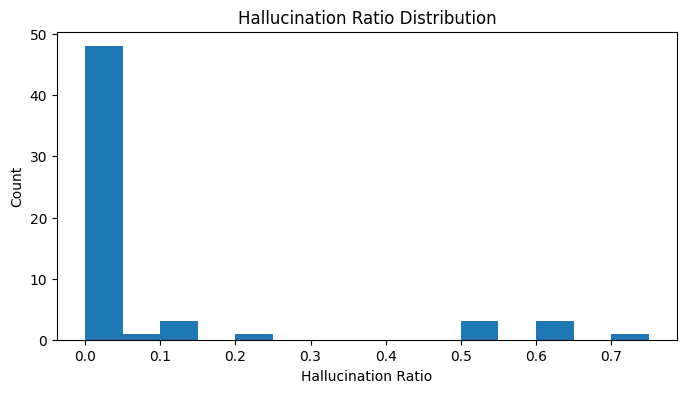

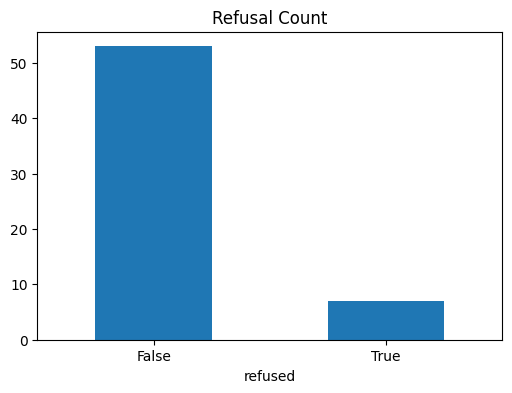

,question,answer,hallucination_ratio,refused
0,What is gravity?,The term gravity is used to describe the force...,0.076923,False
1,What is photosynthesis?,Photosynthesis is the production of organic ma...,0.000000,False
2,Who was Albert Einstein?,The Nobel Prize in Physics in 1921 for theoret...,0.000000,False
3,What is the Moon?,Moon,0.000000,False
4,What is the Sun?,"A large ball of bright, glowing, hot matter in...",0.000000,False


In [18]:
df = full_evaluation(evaluation_questions)
metrics = compute_metrics(df)

print(metrics)
plot_results(df)
df.head()